This notebook is intended as a test of the Heron Gaussian Process regressor using the George Gaussian process package as its back-end. In order to keep memory constraints nice for optimisation we limit the training of the Gaussian Process (GP) to 20 waveforms.

The ultimate goal of this project is to use a GP to provide a surrogate model for BBH waveforms produced using Numerical Relativity (NR) codes. The NR waveforms we will test the method on are extracted from the Georgia Tech (GT) waveform catalogue, however, in order to allow rapid testing, the training data used in this notebook are produced using IMRPhenomP, a Post-Newtonian (PN) approximant. This allows the production of test data to validate the GP model.

In order to select training waveforms we selected the subset of all GT waveforms which are non-spinning, of which there are 44 unique waveforms. This leaves the only free parameter in the model as the mass ratio, $q$, and so we are able to produce the model as a two-dimensional input GP model. These waveforms sample the $q$ parameter space unevenly between $q \in (0.07, 1.0)$.

In [1]:
import george
from heron import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy

The waveforms are produced by the IMRPhenomP function from `LALSimulation`. Below is a function to make the production of these waveforms simpler than the standard Python interface to the function.

In [2]:
import lalsimulation, lal

def generate_new_points(massratio, spin1x, npoints = 300, tstart = -0.1, tend = 0.005):
    """
    
    Parameters
    ----------
    massratio : float
        The ratio of the two component masses.
    spin1x : array
        The vector of spin components for mass 1.
    spin2x : array
        The vector of spin components for mass 2.
    npoints : int
        The desired number of points in the output waveform
    tstart : float
        The start time of the output waveform.
    tend : float
        the end time of the output waveform.
    
    Outputs
    -------
    data : array
        An array of data in the format expected by the heron data object.
    
    """
    chi1_l = 0
    chi2_l = 0
    chip = 0
    thetaJ = 0
    mass2 = 15 * lal.MSUN_SI
    mass1 = mass2 / massratio
    #print mass1 / lal.MSUN_SI
    distance = 5 * lal.PC_SI
    alpha0 = 0
    phic = 0
    f_ref = 100 * lal.HertzUnit,
    waveflags = lalsimulation.SimInspiralCreateWaveformFlags()
    approximant = lalsimulation.SimInspiralGetApproximantFromString("IMRPhenomP")
    #phorder = lalsimulation.SimInspiralGetOrderFromString("IMRPhenomP0")
    #f, ax = plt.subplots(10, sharey=True, figsize=(5,15))
    data = np.zeros((npoints, 4))
    #m1 = mass1 / lal.MSUN_SI
    coaphase = 0
    
    spin1x, spin1y, spin1z = spin1x,0,0
    spin2x, spin2y, spin2z = spin1x,0,0
    flower = 10 
    fref = 10
    distance = 400 *1e6 * lal.PC_SI
    z = 0.0
    inclination = 0.0
    lambda1 = lambda2 = 0.0
    amporder = 0
    phorder = 0
    dt = (tend-tstart)/npoints
    hp, hc = lalsimulation.SimInspiralTD(coaphase, dt, 
                                         mass1, mass2,
                                         spin1x, spin1y, spin1z,
                                         spin2x, spin2y, spin2z,
                                         flower, fref, distance, z,
                                         inclination, lambda1, lambda2,
                                         waveflags, None, amporder, phorder,
                                         approximant
                                        )
    times = np.linspace(0, len(hp.data.data)*hp.deltaT, len(hp.data.data)) + hp.epoch
    data[:,-1] =  hp.data.data[(tstart<times) & (times<tend)]
    data[:,0] = times[(tstart<times) & (times<tend)]
    data[:,1] = massratio * np.ones(npoints)
    data[:,2] = spin1x * np.ones(npoints)
    return data

A quick test on a single waveform. (i.e. a one-dimensional-input GP).

In [130]:
bbh_data = generate_new_points(0.5, 0, 200, tstart=-0.02) #np.vstack([generate_new_points(5, 0), generate_new_points(6, 0)])
bbh_test = generate_new_points(0.5, 0, npoints = 1000)
bbh = data.Data(np.atleast_2d(bbh_data[:,:1]), np.atleast_2d(bbh_data[:,-1]),  
                    target_names = ["Times"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test[:,:1],
                    test_labels = bbh_test[:,-1]
                    )

In [183]:
from george import kernels
from heron import regression
kernel = (np.std(bbh.labels)/1.5) *  kernels.Matern52Kernel(0.015, axes=0, ndim=1)
#kernel = (np.std(bbh.labels)/2) * kernels.ExpSquaredKernel(0.015, axes=0, ndim=1)#

In [184]:
gp = regression.Regressor(bbh, kernel=kernel, yerror = 1e-23, tikh=1e-6)

In [770]:
def rprop(function, dfunction, theta0 = 1.0, step = 0.05, stop = 1e-13,grow = 1.2, shrink = 0.8, step_min = 1e-5, step_max = 0.1, iterations = 100):
    """
    Calculate the optimum of a function using the RPROP algorithm.
    
    Parameters
    ----------
    function : python callable
        The function to be optimised.
    dfunction : python callable
        The derivative of the function to be optimised.
    grow : float
        The factor by which the step size can grow during an update.
    shrink : float
        The factor by which the step size can shrink during an update.
    step_min : float
        The smallest possible size of step.
    step_max : float
        The largest possible size of step.
    """
    if isinstance(theta0, np.ndarray):
        # We're optimising a multidimensional function, so we'll need to make
        # sure that our step sizes come as a vector too.
        step = np.array([step]*len(theta0))
    else:
        step = step
    thetas = [theta0]
    lls = [function(theta0)]
    for i in xrange(iterations):
        if np.any(np.abs(dfunction(theta0))<stop): 
            print "Stopping condition met."
            break
        theta1 = theta0 - np.sign(dfunction(theta0)) * step
        test = (dfunction(theta0) * dfunction(theta1))
        #print test
        step[test > 0] *= grow
        step[test < 0] *= shrink
        if np.any(step < step_min): 
            print "Shrink condition met"
            break
        if np.any(step > step_max): 
            print "Growth condition met"
            break
        #    step[test < 0] /= shrink
        #if np.any(step < step_min): break
        #    step[test > 0] /= grow
        #theta1[0] = -1#0#.5
        thetas.append(theta1)
        lls.append(function(theta1))
        theta0 = theta1
    return theta0, thetas, lls

In [771]:
def gll(theta):
    #gp.gp.mean.set_vector([theta[0]])
    gp.kernel.set_vector(theta[0:])
    return -gp.grad_loglikelihood()
def ll(theta):
    #gp.gp.mean.set_vector([theta[0]])
    gp.kernel.set_vector(theta[0:])
    return -gp.loglikelihood()

In [772]:
result, trace = rprop(ll, gll, gp.kernel.get_vector(), iterations=500, step_max=1e-3, step_min=1e-9)
trace = np.array(trace)

Growth condition met


ValueError: too many values to unpack

In [460]:
print gp.kernel.get_vector()

#gp.gp.mean.set_vector([1.5])
print gp.gp.mean.get_vector()

print gp.loglikelihood()

[-2.14354828 -8.75487526 -4.65517019]
[ 0.5]
587.156599842


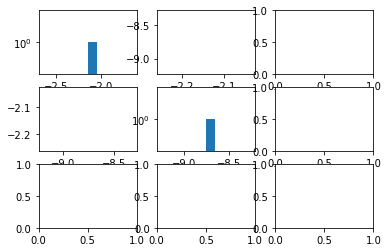

In [461]:
f, ax = plt.subplots(3,3)
#ax[0,2].plot(trace[:,0], trace[:,2], )
ax[0,0].hist(trace[:,0], log=True)
ax[1,1].hist(trace[:,1], log=True)
#ax[2,2].hist(trace[:,2], log=True)
#ax[1,2].plot(trace[:,1], trace[:,2], )
#ax[2,1].plot(trace[:,2], trace[:,1], )
ax[1,0].plot(trace[:,1], trace[:,0], )
ax[0,1].plot(trace[:,0], trace[:,1], )
#ax[2,0].plot(trace[:,2], trace[:,0], )

In [462]:
#gp.optimise()

In [746]:
t = np.linspace(-0.01,0.005, 1000)
new_point = np.zeros((1000,1))
new_point[:,0] = t

In [747]:
t = np.linspace(-0.015,0.005, 1000)
gp.gp.mean.set_vector([0.6])
new_point = np.zeros((1000,1))
new_point[:,0] = t
gp = regression.Regressor(bbh, kernel=kernel, yerror = 1e-23, tikh=1e-6)
gp.optimise()
plt.plot(new_point[:,0], gp.prediction(new_point)[0], label="prediction")
#plt.ylim([-1.5e-22, 1.5e-22]);
#plt.plot(gp.training_data[:,0], gp.training_y)
#print np.mean(gp.training_y)
plt.plot(bbh.denormalise(gp.training_data[:,0], "target"), bbh.denormalise(gp.training_y, "label"), label="training")
plt.legend()

ValueError: Dimension mismatch

In [773]:
# # Georgia Tech Mass ratios
ratios = [ 0.06649688,  0.07314657,  0.07979625,  0.0831211 ,  0.08644594,
        0.09309563,  0.09974532,  0.106395  ,  0.11304469,  0.11636954,
        0.11969438,  0.12634407,  0.13299376,  0.13964344,  0.14629313,
        0.14961798,  0.15294282,  0.15959251,  0.16624219,  0.17289188,
        0.17954157,  0.18619126,  0.19284095,  0.19949063,  0.20614099,
        0.21279001,  0.2194397 ,  0.22608872,  0.23273907,  0.23938943,
        0.24603845,  0.2526888 ,  0.25933716,  0.26598751,  0.27263786,
        0.27928622,  0.28593724,  0.29258693,  0.29923662,  0.33248372,
        0.39898193,  0.46547815,  0.66472407,  1.        ]

In [774]:
test_ratios = ratios[:-1] + np.diff(ratios)/2

In [775]:
ratios[40]

0.39898193

In [776]:
bbh_data_2 = np.vstack([generate_new_points(ratio, 0, 250, tstart=-0.10, tend=0.05) for ratio in ratios[:8:2]])
bbh_test_2 = np.vstack([generate_new_points(ratio, 0, 250, tstart=-0.10, tend=0.05) for ratio in test_ratios[1:8:2]])
                        #generate_new_points(7, 0, 250, tstart=-0.005), 
                        #generate_new_points(9, 0, 250, tstart=-0.005), 
                        #generate_new_points(15, 0, 250,tstart=-0.005)])

#bbh_test_2 = np.vstack([generate_new_points(7, 0, 1000, tstart=-0.005)])#, generate_new_points(10, 0, 1000), generate_new_points(15, 0, 1000)])

In [777]:
bbh_2 = data.Data(bbh_data_2[:,:2], bbh_data_2[:,-1],
    #bbh_text[:,:2], bbh_text[:,-1],              
                    target_names = ["Times", "Mass"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test_2[:,:2],
                    test_labels = bbh_test_2[:,-1]
                    )

In [778]:
def gll(theta):
    #gp.gp.mean.set_vector([theta[0]])
    gp.kernel.set_vector(theta[0:])
    return -gp.grad_loglikelihood()
    #gp.test_predict()
    #return - gp.correlation()
def ll(theta):
    #gp.gp.mean.set_vector([theta[0]])
    gp.kernel.set_vector(theta[0:])
    return -gp.loglikelihood()

In [1]:
#(bbh_2.targets[5,0] - bbh_2.targets[4,0])**2
#k1 = np.std(bbh_2.labels) *  kernels.ExpSquaredKernel(0.0009 , axes = 0, ndim=2)
#k2 =  kernels.ExpSquaredKernel((0.0125)**2, axes = 1, ndim=2)
#k2 =  kernels.ExpSquaredKernel(1**2, axes = 1, ndim=2)

k0 =  np.std(bbh_2.labels)
k1 =  kernels.ExpSquaredKernel(0.00015, axes = 0, ndim=2)
k2 =  kernels.ExpSquaredKernel((1./10.)**2, axes = 1, ndim=2)#(1./39.9)**2, axes = 1, ndim=2)
k3 = kernels.Matern52Kernel(0.00015, axes=0, ndim=2)
kernel = k0 * k3 * k2
gp = regression.Regressor(bbh_2, kernel=kernel, yerror = 1e-23, tikh=1e-6)
#gp.gp.set_vector(np.log([  0.039,   0.005**2,   0.4**2]))
#gp.optimise()

NameError: name 'np' is not defined

In [ ]:
result, trace, lltrace = rprop(ll, gll, gp.kernel.get_vector(), step = 1e-3,  stop = 1e-24, grow = 1.01, shrink = 0.99, step_max=1, step_min=1e-25, iterations=100)

In [ ]:
trace = np.array(trace)
f, ax = plt.subplots(3,3)
ax[0,2].plot(trace[:,0], trace[:,2], )
ax[0,0].hist(trace[:,0], log=True)
ax[1,1].hist(trace[:,1], log=True)
ax[2,2].hist(trace[:,2], log=True)
ax[1,2].plot(trace[:,1], trace[:,2], )
ax[2,1].plot(trace[:,2], trace[:,1], )
ax[1,0].plot(trace[:,1], trace[:,0], )
ax[0,1].plot(trace[:,0], trace[:,1], )
ax[2,0].plot(trace[:,2], trace[:,0], )

In [ ]:
plt.plot(-np.array(lltrace))

In [ ]:
print (gp.kernel.get_vector())

#gp.gp.mean.set_vector([1.5])
print gp.gp.mean.get_vector()

print gp.loglikelihood()

In [788]:
np.array(lltrace).argmin()

667

In [796]:
lltrace[665]

17027.558440162993

In [761]:
trace[359]

array([-5.55291871, -5.34550484, -8.06454061])

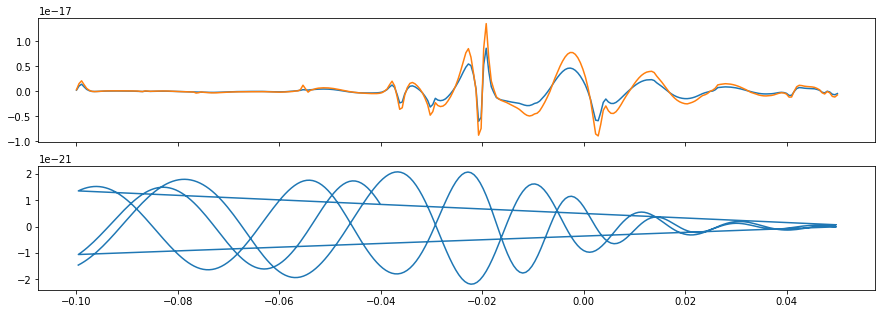

In [797]:
f, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
#test_point = 0
n = 300
#gp.kernel.set_vector([-1.6186423652303596*1.7, -8.94356224, -5.70067603])
#ax[0].plot(bbh_test_2[-1750:-1500, 0], bbh_test_2[-1750:-1500, -1], '+')  
#ax[0].plot(bbh_test_2[-1500:-1250, 0], bbh_test_2[-1500:-1250, -1], '+')    
#ax[0].plot(bbh_test_2[-1250:-1000, 0], bbh_test_2[-1250:-1000, -1], '+')
#ax[0].plot(bbh_test_2[-1000:-750, 0], bbh_test_2[-1000:-750, -1], '+')
gp.kernel.set_vector(trace[665])
gp.gp.mean.set_vector([0.5])
t = np.linspace(-0.1,0.05,n)
new_point = np.zeros((n,2))
new_point[:,1] = 0.07979625-0.003#89188# 0.17299376#0.07349688 + (0.0831211-0.07349688)/2
#new_point[:,2] = 0
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
new_point[:,1] = 0.07979625#-0.004#89188# 0.17299376#0.07349688 + (0.0831211-0.07349688)/2
#new_point[:,2] = 0
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
#ax[0].set_ylim([-.5e-21, .5e-21])
#ax[0].set_xlim([-0.005, 0.005])
err =pred[1]
err2 = err*1.96
#ax[0].fill_between(t, pred[0] - err, pred[0] + err , alpha = 0.2)
#ax[0].fill_between(t, pred[0] - err2, pred[0] + err2 , alpha = 0.1)
##d = test.T[0][1] - test.T[0][0]
#ax[0].plot(test.T[0]+d, test.T[2])
#ax[1].plot(t, np.sqrt((test.T[2] - pred[0])**2))
ax[1].plot(bbh_2.denormalise(bbh_2.targets[0:600], "target")[:,0],
            bbh_2.denormalise(bbh_2.labels[0:600], "label"))
#ax[0].plot(bbh_test_2[-15900:-1,0], bbh_test_2[-250:-1,-1])
           #bbh_2.denormalise(bbh_2.test_labels[0:1000], "label"))


In [733]:
gp.test_predict()
gp.correlation()

0.99293550661287033

In [655]:
gp.rmse()

9.5044871981970479e-22

The expected improvement through the parameter space.

In [24]:
times = np.linspace(-0.1,0.05,100)
ratios = np.linspace(0.07, 0.7, 100)
data = np.zeros((100,100))
xv, yv = np.meshgrid(times, ratios, sparse=False, indexing='ij')
for i in xrange(100):
    for j in xrange(100):
        data[i][j] = gp.expected_improvement([xv[i,j], yv[i,j]])

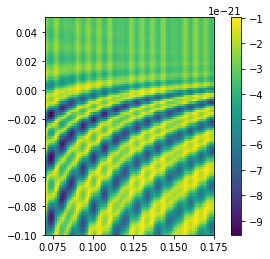

In [25]:
plt.imshow(data, extent=(0.07,0.7, -0.1, 0.05), interpolation="none", aspect=0.9, origin='lower')
plt.colorbar()

In [1]:
gp

NameError: name 'gp' is not defined

In [75]:
times = np.linspace(-0.1,0.05,100)
ratios = np.linspace(0.07, 0.7, 100)
pdata = np.zeros((100,100))
udata = np.zeros((100,100))
xv, yv = np.meshgrid(times, ratios, sparse=False, indexing='ij')
for i in xrange(100):
    for j in xrange(100):
        pdata[i][j], udata[i][j] = gp.prediction([[xv[i,j], yv[i,j]]])

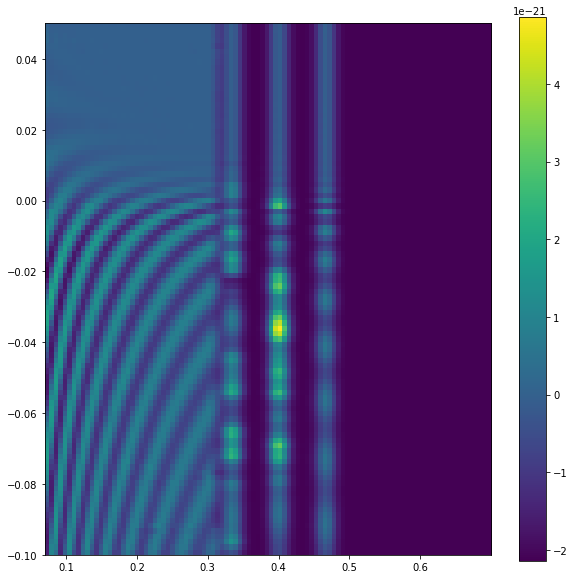

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(pdata, extent=(0.07,0.7, -0.1, 0.05), interpolation="none", aspect=5, origin='lower')
plt.colorbar()

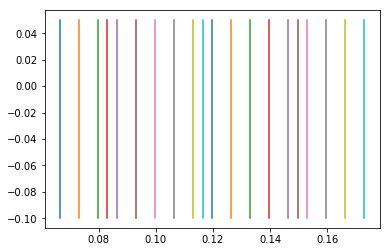

In [28]:
for i in range(len(bbh_data_2[:,0])/250):
    plt.plot(bbh_data_2[250*i:250*(i+1),1], bbh_data_2[250*i:250*(i+1),0])

(-0.1, 0.05)

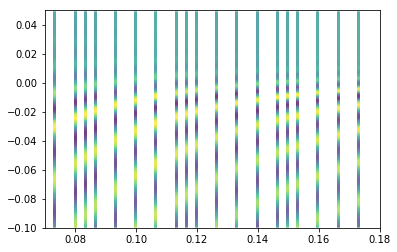

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

fig2 = plt.figure()
for i in range(len(bbh_data_2[:,0])/250):
    x = bbh_data_2[250*i:250*(i+1),1]
    y = bbh_data_2[250*i:250*(i+1),0]
    t = bbh_data_2[250*i:250*(i+1),-1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'),
                        )
    lc.set_array(t)
    lc.set_linewidth(3)

    plt.gca().add_collection(lc)
plt.xlim([0.07, 0.18])
plt.ylim([-0.10, 0.05])

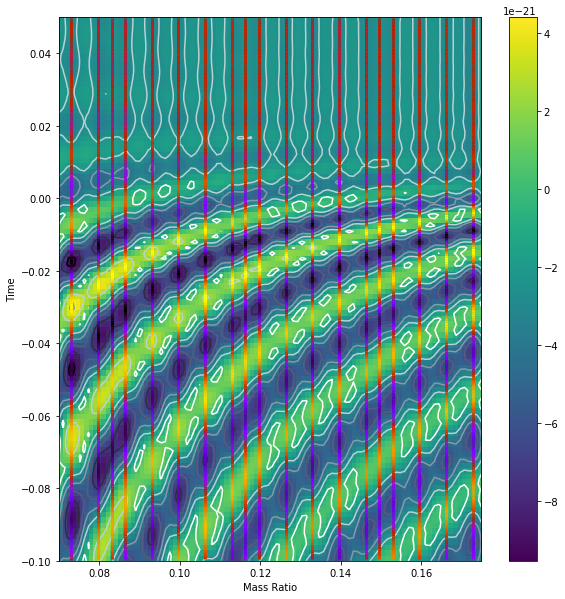

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

plt.figure(figsize=(10,10))
plt.imshow(pdata, extent=(0.07,0.175, -0.1, 0.05), 
           interpolation="none", aspect=0.9, origin='lower')
plt.colorbar()
plt.contour(data, extent=(0.07,0.175, -0.1, 0.05), cmap="bone")
for i in range(len(bbh_data_2[:,0])/250):
    x = bbh_data_2[250*i:250*(i+1),1]
    y = bbh_data_2[250*i:250*(i+1),0]
    t = bbh_data_2[250*i:250*(i+1),-1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('gnuplot'))
    lc.set_array(t)
    lc.set_linewidth(3)

    plt.gca().add_collection(lc)


plt.xlim([0.07, 0.175])
plt.ylim([-0.10, 0.05])
plt.xlabel('Mass Ratio')
plt.ylabel('Time')
#plt.savefig("time-mass.png")

In [8]:
waveforms = []
test_waveforms = []
for spin in [0.0, 0.1, 0.2]:
    for ratio in ratios[:42]:
        waveforms.append(generate_new_points(ratio, spin, 250, tstart=-0.10, tend=0.05))
for spin in [0.05, 0.15]:
    for ratio in test_ratios[:42]:
        test_waveforms.append(generate_new_points(ratio, spin, 250, tstart=-0.10, tend=0.05))      

In [9]:
bbh_data_3 = np.vstack(waveforms)
bbh_test_3 = np.vstack(test_waveforms)
                        #generate_new_points(7, 0, 250, tstart=-0.005), 
                        #generate_new_points(9, 0, 250, tstart=-0.005), 
                        #generate_new_points(15, 0, 250,tstart=-0.005)])

#bbh_test_2 = np.vstack([generate_new_points(7, 0, 1000, tstart=-0.005)])#, generate_new_points(10, 0, 1000), generate_new_points(15, 0, 1000)])

In [10]:
bbh_3 = data.Data(bbh_data_3[:,:3], bbh_data_3[:,-1],
    #bbh_text[:,:2], bbh_text[:,-1],              
                    target_names = ["Times", "Mass", "Spin"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test_3[:,:3],
                    test_labels = bbh_test_3[:,-1]
                    )

In [ ]:
#(bbh_2.targets[5,0] - bbh_2.targets[4,0])**2
#k1 = np.std(bbh_2.labels) *  kernels.ExpSquaredKernel(0.0009 , axes = 0, ndim=2)
#k2 =  kernels.ExpSquaredKernel((0.0125)**2, axes = 1, ndim=2)
#k2 =  kernels.ExpSquaredKernel(1**2, axes = 1, ndim=2)

k0 =  np.std(bbh_3.labels)
k1 =  kernels.ExpSquaredKernel(0.00015, axes = 0, ndim=3)
k2 =  kernels.ExpSquaredKernel((1./39.9)**2, axes = 1, ndim=3)
k4 =  kernels.ExpSquaredKernel((1./3.)**2, axes = 2, ndim=3)
k3 = kernels.Matern52Kernel(0.00015, axes=0, ndim=3)
kernel = k0 * k4 * k3 * k2
gp = regression.Regressor(bbh_3, kernel=kernel, yerror = 1e-23, tikh=1e-6)
#gp.gp.set_vector(np.log([  0.039,   0.005**2,   0.4**2]))
#gp.optimise()

In [2]:
python 

NameError: name 'plt' is not defined